# IMECA's PM10 Cuauh limpieza por día (v3)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter("ignore")

plt.style.use('bmh')

In [16]:
def mape(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def smape(y_true,y_pred):
    return ((y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).mean() * 200

In [17]:
def imeca_calculation(a):
    imeca = []
    for e in a:
        e=round(e)
        if (e>0)&(e<=40):
            k= (50-0)/(40-0)
            im=k*(e-0) + 0
            imeca.append(round(im))

        elif (e>=41) & (e<=75):
            k=(100-51)/(75-41)
            im=k*(e-41) + 51
            imeca.append(round(im))

        elif (e>=76) & (e<=214):
            k=(150-101)/(214-76)
            im=k*(e-76) + 101
            imeca.append(round(im))

        elif (e>=215) & (e<=354):
            k=(200-151)/(354-215)
            im=k*(e-215) + 151
            imeca.append(round(im))

        elif (e>=355) & (e<=424):
            k=(300-201)/(424-355)
            im=k*(e-355) + 201
            imeca.append(round(im))

    return imeca

In [18]:
def categorizando(df):
    lst=[]
    for e in df:
        if (e>=0) & (e<50):
            lst.append('Buena')
        elif (e>=50) & (e<100):
            lst.append('Regular')
        elif (e>=100) & (e<150):
            lst.append('Mala')
        elif (e>=150) & (e<200):
            lst.append('Muy mala')
        else:
            lst.append('Ya vete de aquí woe')
    return lst

In [19]:
def comparando_categorias(a,b):
    lst=[]
    for e in range(len(a)):
        if a[e] == b[e]:
            lst.append(1)
        else:
            lst.append(0)
    return lst

### Leyendo CSV de IMECA's directos

In [66]:
cuauh_imeca_real = pd.read_excel("../data_aircdmx/imeca2019.xls")

In [67]:
cuauh_imeca_real.Hora[cuauh_imeca_real.Hora==24] = 00
cuauh_imeca_real.Fecha=cuauh_imeca_real.Fecha.apply(str)
cuauh_imeca_real.Fecha=cuauh_imeca_real.Fecha.apply(lambda x: x.replace(' 00:00:00',''))
cuauh_imeca_real['DATETIME']=cuauh_imeca_real.Fecha + ' ' + cuauh_imeca_real.Hora.apply(str)+':00:00'
#df.DATETIME=df.DATETIME.apply(lambda x: x.replace(' 00:00:00',''))
cuauh_imeca_real.DATETIME=pd.to_datetime(cuauh_imeca_real.DATETIME)

In [68]:
cuauh_imeca_real.DATETIME.tail()

7291   2019-10-31 20:00:00
7292   2019-10-31 21:00:00
7293   2019-10-31 22:00:00
7294   2019-10-31 23:00:00
7295   2019-10-31 00:00:00
Name: DATETIME, dtype: datetime64[ns]

In [69]:
cuauh_imeca_real=cuauh_imeca_real[['DATETIME','Centro PM10']]
cuauh_imeca_real=cuauh_imeca_real.set_index('DATETIME')

cuauh_imeca_mean=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).mean()
cuauh_imeca_max=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).max()
cuauh_imeca_median=cuauh_imeca_real.groupby(pd.TimeGrouper('D')).median()

## Ejecución del modelo

In [8]:
cuauh_clean_max = pd.read_csv("../data_clean/cuauh_pm10_max_clean_v3.csv",index_col=[0])
cuauh_clean_median = pd.read_csv("../data_clean/cuauh_pm10_median_clean_v3.csv",index_col=[0])
cuauh_clean_mean = pd.read_csv("../data_clean/cuauh_pm10_mean_clean_v3.csv",index_col=[0])

In [319]:
split_date2='2019-01-01'
split_date1='2015-11-01'

#### Para el valor Máximo ######
train=cuauh_clean_max[(cuauh_clean_max.index>=split_date1)&(cuauh_clean_max.index<split_date2)].copy()
test=cuauh_clean_max[cuauh_clean_max.index>split_date2].copy()

#### Para la Mediana ######
train2=cuauh_clean_median[(cuauh_clean_median.index>=split_date1)&(cuauh_clean_median.index<split_date2)].copy()
test2=cuauh_clean_median[cuauh_clean_median.index>split_date2].copy()

#### Para la Mean ######
train3=cuauh_clean_mean[(cuauh_clean_mean.index>=split_date1)&(cuauh_clean_mean.index<split_date2)].copy()
test3=cuauh_clean_mean[cuauh_clean_mean.index>split_date2].copy()

### Preparando para fbprophet

In [320]:
train=train.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test=test.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train.ds=pd.to_datetime(train.ds)
test.ds=pd.to_datetime(test.ds)
test=test.dropna()
###############################################################################
train2=train2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test2=test2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train2.ds=pd.to_datetime(train2.ds)
test2.ds=pd.to_datetime(test2.ds)
test2=test2.dropna()
###############################################################################
train3=train3.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test3=test3.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train3.ds=pd.to_datetime(train3.ds)
test3.ds=pd.to_datetime(test3.ds)
test3=test3.dropna()

In [321]:
modelo=Prophet(#n_changepoints=15,
               #growth='linear',
               #holidays=holidays_df,
               #changepoints=['2016-01-01','2017-02-01','2018-01-01','2018-12-31'],
               #changepoint_prior_scale=0.65,
               #daily_seasonality=True,
               #yearly_seasonality=15,
               #weekly_seasonality=True,
               #daily_seasonality=False,
               #yearly_seasonality=True,
               #seasonality_prior_scale = 15,
               #seasonality_mode='multiplicative',
               #interval_width=0.95
              ).fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [322]:
pred=modelo.predict(test)

In [323]:
mape(test.y, pred.yhat), smape(test.y, pred.yhat)

(25.783192276691068, 22.18111282180053)

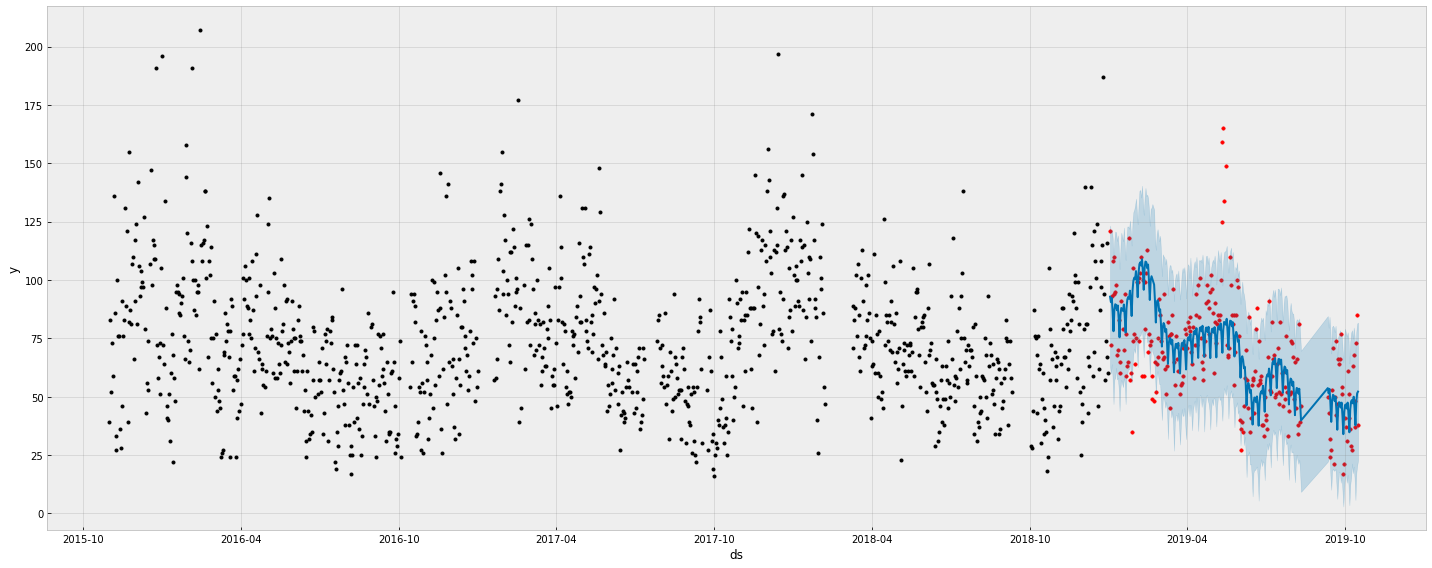

In [324]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(test.ds, test.y, color='r',s=12)
fig=modelo.plot(pred, ax)

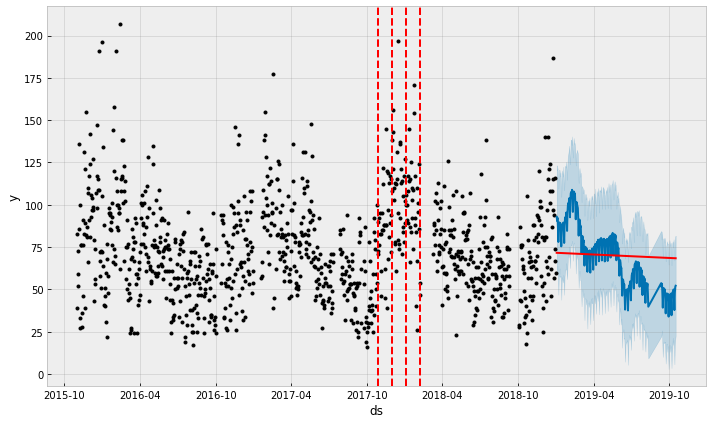

In [325]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo
fig = modelo.plot(pred)
a = add_changepoints_to_plot(fig.gca(), modelo, pred)

In [326]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,71.648371,62.811294,123.321463,71.648371,71.648371,21.219706,21.219706,21.219706,3.202509,3.202509,3.202509,18.017197,18.017197,18.017197,0.0,0.0,0.0,92.868077
1,2019-01-03,71.637176,59.952264,120.453574,71.637176,71.637176,18.866711,18.866711,18.866711,1.340442,1.340442,1.340442,17.526269,17.526269,17.526269,0.0,0.0,0.0,90.503887
2,2019-01-04,71.625981,63.936544,121.699452,71.625981,71.625981,20.719916,20.719916,20.719916,3.706110,3.706110,3.706110,17.013806,17.013806,17.013806,0.0,0.0,0.0,92.345897
3,2019-01-05,71.614786,57.464317,118.032993,71.614786,71.614786,14.687979,14.687979,14.687979,-1.802769,-1.802769,-1.802769,16.490748,16.490748,16.490748,0.0,0.0,0.0,86.302765
4,2019-01-06,71.603590,46.872318,109.541616,71.603590,71.603590,6.458751,6.458751,6.458751,-9.510307,-9.510307,-9.510307,15.969058,15.969058,15.969058,0.0,0.0,0.0,78.062341


# Comparación directa de IMECA

### Predicción

In [327]:
df_pred=pd.DataFrame(pred[['ds','yhat_upper']])
df_pred=df_pred.set_index('ds')

In [328]:
df_pred.shape

(254, 1)

In [329]:
df_pred.isnull().sum() #13 NANs
df_pred=df_pred.dropna()

In [330]:
df_pred.shape

(254, 1)

In [331]:
df_pred['imeca_pred']=imeca_calculation(df_pred.yhat_upper)
df_pred.head()

,yhat_upper,imeca_pred
ds,,
2019-01-02,123.321463,118
2019-01-03,120.453574,117
2019-01-04,121.699452,117
2019-01-05,118.032993,116
2019-01-06,109.541616,113


### Cuauh's IMECA real

In [332]:
cuauh_imeca_max.head()

,Centro PM10
DATETIME,
2019-01-01,115
2019-01-02,114
2019-01-03,106
2019-01-04,101
2019-01-05,106


In [333]:
df_comparison=df_pred.join(cuauh_imeca_max)[['yhat_upper','imeca_pred','Centro PM10']]
df_comparison['categoria_pred']=categorizando(df_comparison.imeca_pred)
df_comparison['categoria_real']=categorizando(df_comparison['Centro PM10'])
df_comparison['comparacion_imecas']=comparando_categorias(df_comparison.categoria_pred,df_comparison.categoria_real)

In [334]:
df_comparison.comparacion_imecas.value_counts()

0    223
1     31
Name: comparacion_imecas, dtype: int64

In [335]:
223/254

0.8779527559055118

In [291]:
df_comparison

,yhat_upper,imeca_pred,Centro PM10,categoria_pred,categoria_real,comparacion_imecas
ds,,,,,,
2019-01-02,65.456250,86,114,Regular,Mala,0
2019-01-03,65.354419,86,106,Regular,Mala,0
2019-01-04,65.184418,86,101,Regular,Mala,0
2019-01-05,61.219379,80,106,Regular,Mala,0
2019-01-06,57.722556,76,105,Regular,Mala,0
2019-01-07,61.540239,81,104,Regular,Mala,0
2019-01-08,63.871750,84,103,Regular,Mala,0
2019-01-09,62.906697,83,100,Regular,Mala,0
2019-01-10,63.176235,83,86,Regular,Regular,1


## Explorando holidays

In [74]:
# import holidays

In [77]:
# holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [78]:
# ldates = []
# lnames = []
# for date, name in sorted(holidays.MX(years=np.arange(2015, 2019)).items()):
#     ldates.append(date)
#     lnames.append(name)

In [79]:
# ldates = np.array(ldates)
# lnames = np.array(lnames)

In [336]:
# holidays_df.loc[:,'ds'] = ldates
# holidays_df.loc[:,'holiday'] = lnames
# holidays_df.holiday